In [76]:
library(Seurat)
library(ggplot2)
library(tidyverse)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.1       ✔ purrr   0.3.4  
✔ tidyr   0.8.3       ✔ dplyr   0.8.0.1
✔ readr   1.3.1       ✔ stringr 1.4.0  
✔ tibble  2.1.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
# load preprocessed Seurat object
path = "/data/rq25/liliana_10x_human_TIL_202003/seurat_analysis/integrated_data_S.rds"
data = readRDS(path)

In [3]:
data

An object of class Seurat 
45068 features across 58615 samples within 1 assay 
Active assay: RNA (45068 features, 2000 variable features)
 2 dimensional reductions calculated: pca, tsne

In [4]:
unique(data@meta.data$orig.ident) # BL: blood, TIL: tumor

[1] "YUTAS_BL_CD8"      "YUTAS_BL_TEFF"     "YUTAS_BL_TREG"    
[4] "YUTAS_TIL_CD8"     "YUTAS_TIL_TEFF"    "YUTAS_TIL_TREG"   
[7] "YUTAS_TIL_exp"     "YUTAS_BL_initial"  "YUTAS_TIL_initial"

## Extract subset of CD8 cells in blood and TIL

In [10]:
is_blood_cd8 = data@meta.data$orig.ident == "YUTAS_BL_CD8"
is_tumor_cd8 = data@meta.data$orig.ident == "YUTAS_TIL_CD8"

In [11]:
cd8 = data[,is_blood_cd8 | is_tumor_cd8]

In [12]:
cd8

An object of class Seurat 
45068 features across 11025 samples within 1 assay 
Active assay: RNA (45068 features, 2000 variable features)
 2 dimensional reductions calculated: pca, tsne

In [30]:
# rerun PCA
cd8 <- FindVariableFeatures(cd8, selection.method = "vst", nfeatures = 2000)

In [32]:
head(VariableFeatures(cd8), 10)

[1] "CCL4"     "CCL4L2"   "TRBV4-2"  "XCL1"     "TRBV12-3" "TUBA1B"  
 [7] "XCL2"     "TRBV12-4" "TRBV4-1"  "CXCL13"

In [36]:
# mask the 86 TCR genes from PCA analysis
to_mask <- purrr::map_lgl(rownames(cd8), ~grepl("^TRB", .x))
cd8_masked <- FindVariableFeatures(cd8[!to_mask,], selection.method = "vst", nfeatures = 2000)

In [43]:
head(VariableFeatures(cd8_masked), 10)

[1] "CCL4"     "CCL4L2"   "XCL1"     "TUBA1B"   "XCL2"     "CXCL13"  
 [7] "STMN1"    "CCL3"     "HIST1H4C" "HSPA1A"

In [44]:
cd8_masked <- ScaleData(cd8_masked, features = rownames(cd8_masked))

Centering and scaling data matrix


In [46]:
cd8_masked <- RunPCA(cd8_masked, features = VariableFeatures(object = cd8_masked), verbose = F)

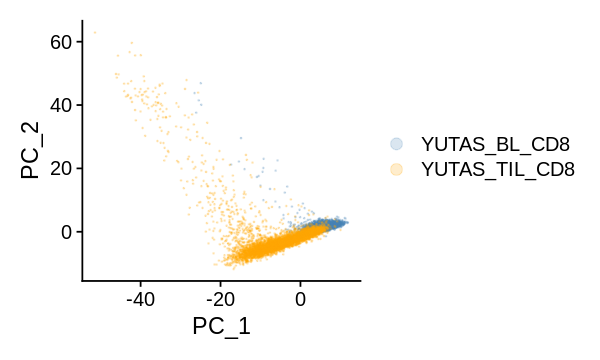

In [61]:
options(repr.plot.width = 5, repr.plot.height = 3)
DimPlot(cd8_masked, reduction = "pca") +
 scale_color_manual(values = alpha(c("steelblue", "orange"), 0.2))

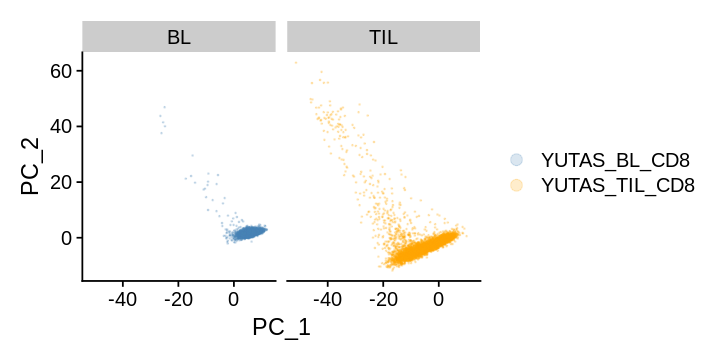

In [58]:
options(repr.plot.width = 6, repr.plot.height = 3)
DimPlot(cd8_masked, reduction = "pca") +
 scale_color_manual(values = alpha(c("steelblue", "orange"), 0.2)) +
 facet_wrap(~ purrr::map_chr(cd8_masked@meta.data$orig.ident, ~strsplit(.x, "_")[[1]][2]))

The overall shape of the embedded data looks quite similar and batch effect might be causing the differences. We will analyze the data separately for now. 

In [64]:
blood_cd8 = cd8_masked[,cd8_masked@meta.data$orig.ident == "YUTAS_BL_CD8"]
tumor_cd8 = cd8_masked[,cd8_masked@meta.data$orig.ident == "YUTAS_TIL_CD8"]

Let's analyze tumor CD8 first which may appears to be more diverse in phenotype than blood samples. 

In [66]:
tumor_cd8

An object of class Seurat 
44982 features across 5376 samples within 1 assay 
Active assay: RNA (44982 features, 2000 variable features)
 2 dimensional reductions calculated: pca, tsne

In [69]:
tumor_cd8 = FindVariableFeatures(tumor_cd8, selection.method = "vst", nfeatures = 2000)
tumor_cd8 <- ScaleData(tumor_cd8, features = rownames(tumor_cd8), verbose = F)
tumor_cd8 <- RunPCA(tumor_cd8, features = VariableFeatures(object = tumor_cd8), verbose = F)

In [ ]:
tumor_cd8 <- FindNeighbors(tumor_cd8, dims = 1:10)

In [71]:
tumor_cd8 <- FindClusters(tumor_cd8, resolution = 0.5)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5376
Number of edges: 172333

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8431
Number of communities: 9
Elapsed time: 0 seconds


In [ ]:
tumor_cd8 <- RunUMAP(tumor_cd8, dims = 1:10)

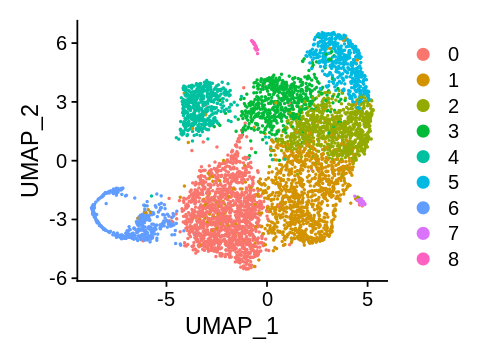

In [73]:
DimPlot(tumor_cd8, reduction = "umap")

In [ ]:
tumor_cd8_markers <- FindAllMarkers(tumor_cd8, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Here are top 2 upregulated genes for each marker from differential expression analysis. 

In [96]:
top_3_per_cluster = tumor_cd8_markers %>% group_by(cluster) %>% top_n(n = 3, wt = avg_logFC)
top_3_per_cluster[,c(6,7,2,3,4)]

cluster,gene,avg_logFC,pct.1,pct.2
0,MIR155HG,1.2527050,0.717,0.230
0,AC133644.2,1.1523780,0.691,0.244
0,CCL3,1.1315765,0.641,0.269
1,XCL1,1.9354481,0.870,0.293
1,XCL2,1.8114868,0.716,0.198
1,CCL4L2,0.8423025,0.375,0.298
2,IL7R,1.4804806,0.771,0.203
2,LTB,0.9346323,0.750,0.409
2,SELL,0.7268942,0.361,0.137
3,GZMH,0.8651690,0.830,0.513


In [99]:
plist = FeaturePlot(tumor_cd8, features = top_3_per_cluster$gene, combine = F)
p1 <- list() 
for (i in seq_along(plist)){
    #Change x and y tick label font size.
    p1[[i]] = plist[[i]] + theme(axis.text = element_blank(), 
                                 axis.title = element_blank(),
                                axis.ticks = element_blank(), 
                                legend.position = "none") 
}

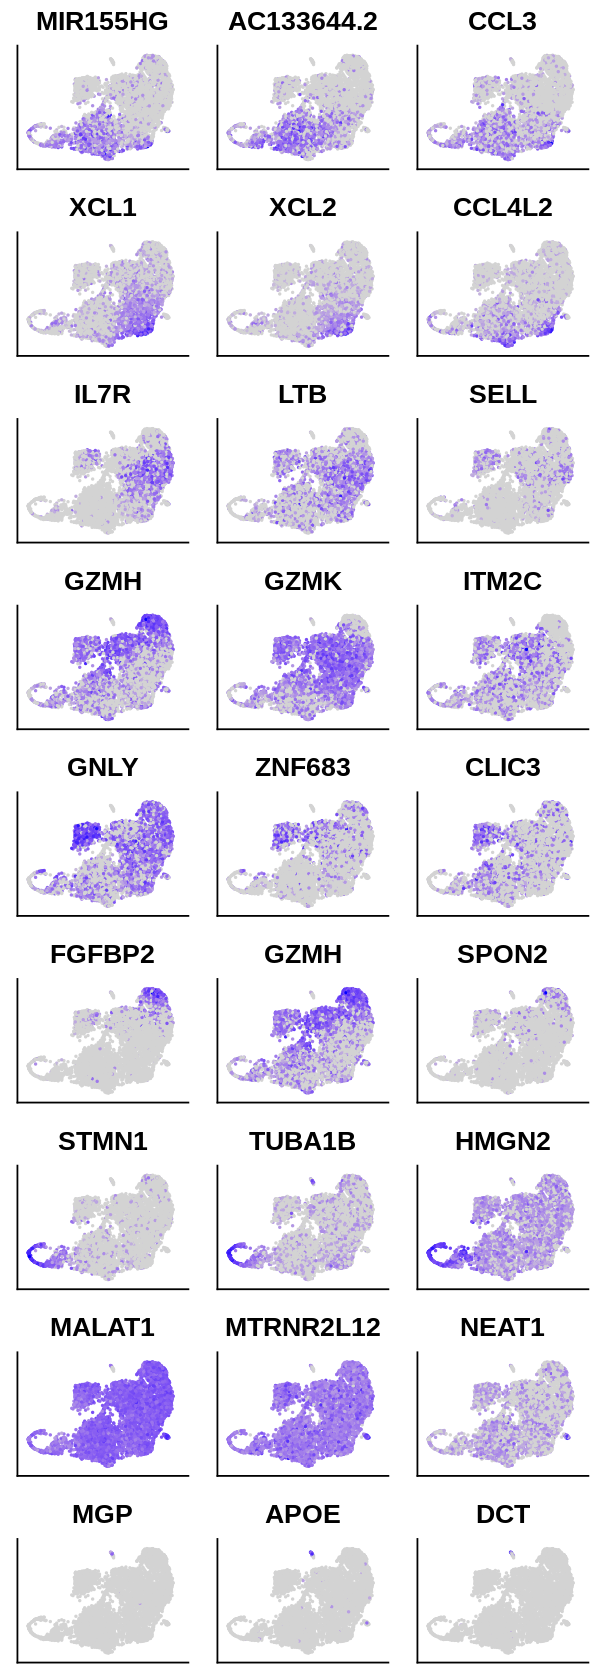

In [101]:
options(repr.plot.width = 5, repr.plot.height = 14)

cowplot::plot_grid(plotlist = p1, ncol = 3) 

Cluster 7 appears to be cycling cells, 8 and 9 may not be T cells?

## Test trajectory analysis using Slingshot

We exclude the last three cells from the analysis for now. 